## Skin Cancer Detection 
By Effy Fang, Ying Huang, Kai Li

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
import seaborn as sns
from PIL import Image

## load data

In [26]:
folder_benign_train = 'Data/train/benign'
folder_malignant_train = 'Data/train/malignant'

folder_benign_test = 'Data/test/benign'
folder_malignant_test = 'Data/test/malignant'

In [27]:
#load train file
read = lambda imname: np.asarray(Image.open(imname).convert("RGB"))
ims_benign = [read(os.path.join(folder_benign_train, filename)) for filename in os.listdir(folder_benign_train)]
X_benign = np.array(ims_benign, dtype='uint8')
ims_malignant = [read(os.path.join(folder_malignant_train, filename)) for filename in os.listdir(folder_malignant_train)]
X_malignant = np.array(ims_malignant, dtype='uint8')

# Load in testing pictures
ims_benign = [read(os.path.join(folder_benign_test, filename)) for filename in os.listdir(folder_benign_test)]
X_benign_test = np.array(ims_benign, dtype='uint8')
ims_malignant = [read(os.path.join(folder_malignant_test, filename)) for filename in os.listdir(folder_malignant_test)]
X_malignant_test = np.array(ims_malignant, dtype='uint8')

In [28]:
#create labels for train
y_benign = np.zeros(X_benign.shape[0])
y_malignant = np.ones(X_malignant.shape[0])
#for test
y_benign_test = np.zeros(X_benign_test.shape[0])
y_malignant_test = np.ones(X_malignant_test.shape[0])

In [29]:
#Merge data
X_train = np.concatenate((X_benign, X_malignant), axis = 0)
y_train = np.concatenate((y_benign, y_malignant), axis = 0)

X_holdout = np.concatenate((X_benign_test, X_malignant_test), axis = 0)
y_holdout = np.concatenate((y_benign_test, y_malignant_test), axis = 0)

#shuffle
np.random.seed(0)
s = np.arange(X_train.shape[0])
np.random.shuffle(s)
X_train = X_train[s]
y_train = y_train[s]

np.random.seed(0)
s = np.arange(X_holdout.shape[0])
np.random.shuffle(s)
X_holdout = X_holdout[s]
y_holdout = y_holdout[s]

In [6]:
#X_train.shape
X_holdout.shape

(660, 224, 224, 3)

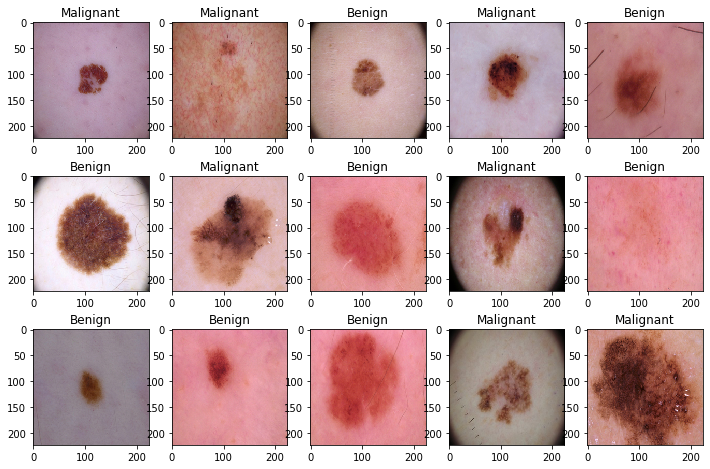

In [7]:
# Display first 15 images of moles, and how they are classified
w=40
h=30
fig=plt.figure(figsize=(12, 8))
columns = 5
rows = 3

for i in range(1, columns*rows +1):
    ax = fig.add_subplot(rows, columns, i)
    if y_train[i] == 0:
        ax.title.set_text('Benign')
    else:
        ax.title.set_text('Malignant')
    plt.imshow(X_train[i], interpolation='nearest')
plt.show()

In [8]:
X_train[0].shape

(224, 224, 3)

## Normalization

In [30]:
#normalize
X_train = X_train/255
X_holdout = X_holdout/255

In [31]:
X_train_reshaped = X_train.reshape((X_train.shape[0],-1))

## PCA

In [32]:
#PCA
from sklearn.decomposition import PCA

# split the data
from sklearn.model_selection import train_test_split

y_train_label=y_train
X_train,X_test,y_train,y_test=train_test_split(X_train_reshaped,y_train_label,test_size=0.2,random_state=0)

pca = PCA(copy=True).fit(X_train)

In [12]:
def plot_scaled_variance(pca):
    '''
    Plots the variance explained by each of the principal components.
    Features are scaled with sklearn.StandardScaler.
    
    Parameters
    ----------
    pca: An sklearn.decomposition.pca.PCA instance.
    
    Returns
    -------
    A matplotlib.Axes instance.
    '''
    
    # YOUR CODE HERE
    plt.plot(pca.explained_variance_ratio_)
    plt.xlabel('Dimension #')
    plt.ylabel('Explained Variance Ratio')
    plt.title('Fraction of Explained Variance')
    ax = plt.gca()
    
    
    
    return ax

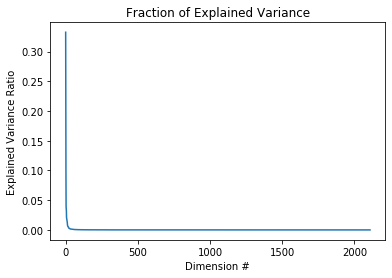

In [13]:
ax = plot_scaled_variance(pca)

In [14]:
print(np.where(np.cumsum(pca.explained_variance_ratio_)>0.9)[0][0]) #42 features explains more than 90% variance 
print(np.where(np.cumsum(pca.explained_variance_ratio_)>0.95)[0][0])

41
158


In [33]:
pca42 = PCA(copy=True, n_components=42)
pca42.fit(X_train)
X_train_reduced=pca42.transform(X_train)
X_test_reduced=pca42.transform(X_test)
X_reduced = pca42.transform(X_train_reshaped)

X_holdout_reshaped = X_holdout.reshape((X_holdout.shape[0],-1))
X_holdout_reduced=pca42.transform(X_holdout_reshaped)

In [24]:
# saving the pca reduced data 
#np.save('X_train_reduced.npy', X_train_reduced)
#np.save('X_test_reduced.npy', X_test_reduced)
np.save('X_reduced.npy', X_reduced)
#np.save('X_holdout_reduced.npy', X_holdout_reduced)

#np.save('y_train.npy', y_train)
#np.save('y_test.npy', y_test)
#np.save('y_holdout.npy', y_holdout)

In [41]:
# to read the file 
X_train_reduced = np.load('X_train_reduced.npy')
X_test_reduced = np.load('X_test_reduced.npy')
X_holdout_reduced = np.load('X_holdout_reduced.npy')

y_train = np.load('y_train.npy')
y_test = np.load('y_test.npy')
y_holdout = np.load('y_holdout.npy')

In [3]:
X_train_reduced.shape

(2109, 42)

## Model Fitting

In [4]:
from sklearn import svm
# import the class
from sklearn.linear_model import LogisticRegression


from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

from sklearn.ensemble import AdaBoostClassifier

from sklearn import metrics
from sklearn.model_selection import cross_val_score

In [6]:

# instantiate the model (using the default parameters)
log_model = LogisticRegression()
C = 1.0  # SVM regularization parameter

# LinearSVC (linear kernel)
lin_svc = svm.LinearSVC(C=C)
#SVC with RBF kernel
rbf_svc = svm.SVC(kernel='rbf', C=C)
# SVC with polynomial (degree 3) kernel
poly_svc = svm.SVC(kernel='poly', C=C)
# decision tree
dt = DecisionTreeClassifier(random_state=0)
# random forest 
rf = RandomForestClassifier(random_state=0)

# Import AdaBoostClassifier
ada = AdaBoostClassifier(base_estimator=dt, random_state=0)

models = [log_model, lin_svc, rbf_svc, poly_svc, rf, ada]

names = ['Logistic Regression', 'SVC(linear kernal)','SVC(RBF)','SVC(polynomial)','Random Forest','Ada Boosting']

reports=[]
f1_score=[]
precision=[]
recall=[]
acc=[]

for model in models: 
    # fit the model
    model.fit(X_train_reduced,y_train)
    # predict on the test set 
    y_pred=model.predict(X_test_reduced)
    # save the scores for comparison 
    report=metrics.classification_report(y_test, y_pred,output_dict=True)
    reports.append(report)
    f1_score.append(report['weighted avg']['f1-score'])
    precision.append(report['weighted avg']['precision'])
    recall.append(report['weighted avg']['recall'])
    acc.append(metrics.accuracy_score(y_test,y_pred))
    
models_df=pd.DataFrame({'models':names, 'accuracy':acc,'f1_score':f1_score,'precision':precision, 'recall':recall})
models_df.round(3).sort_values(by='accuracy', ascending=False)

/Users/apple/anaconda3/envs/tensorflow/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/apple/anaconda3/envs/tensorflow/lib/python3.7/site-packages/sklearn/svm/base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/Users/apple/anaconda3/envs/tensorflow/lib/python3.7/site-packages/sklearn/svm/base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
/Users/apple/anaconda3/envs/tensorflow/lib/python3.7/site-packages/sklearn/svm/base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unsc

,models,accuracy,f1_score,precision,recall
0,Logistic Regression,0.786,0.786,0.786,0.786
4,Random Forest,0.784,0.783,0.784,0.784
5,Ada Boosting,0.758,0.757,0.757,0.758
3,SVC(polynomial),0.737,0.736,0.736,0.737
1,SVC(linear kernal),0.674,0.674,0.675,0.674
2,SVC(RBF),0.564,0.419,0.756,0.564


## Cross Validation 

We did 5-fold cross validation on the top 3 models to check model stability

In [23]:
cv_models=[log_model, rf, ada]
cv_names= ['Logistic Regression', 'Random Forest','Ada Boosting']
acc_mean=[]
acc_high=[]
acc_low=[]

for model in cv_models:
    scores = cross_val_score(model, X_train_reduced, y_train, scoring='accuracy', cv=5)
    #scores = cross_val_score(model, X_train, y_train, scoring='accuracy',cv=5)
    acc_mean.append(scores.mean())
    acc_high.append(scores.max())
    acc_low.append(scores.min())

cv_df=pd.DataFrame({'models':cv_names, 'acc_mean':acc_mean,'acc_high':acc_high,'acc_low':acc_low})
cv_df.round(3).sort_values(by='acc_mean', ascending=False)

,models,acc_mean,acc_high,acc_low
1,Random Forest,0.830,0.855,0.810
0,Logistic Regression,0.783,0.806,0.772
2,Ada Boosting,0.724,0.787,0.694


The accuracy scores are pretty even across 5 folds. 

## Parameter Tuning

We tuned the hyperparameters to improve model performance. 

In [5]:
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV

In [53]:
# random forest 
param_grid = {'n_estimators':[10,50,100,500],
              'max_features':[10,20,'auto','log2'],
              'max_depth':[10,50,100,None],
              'criterion':['gini', 'entropy']}
rf_grid = GridSearchCV(rf, param_grid, cv = 5, scoring = 'accuracy',refit = True, n_jobs=-1, verbose = 5)
#rf_grid = RandomizedSearchCV(rf, param_grid, cv = 5, scoring = 'accuracy',refit = True, n_jobs=-1, verbose = 5)
rf_grid.fit(X_train_reduced, y_train)

Fitting 5 folds for each of 128 candidates, totalling 640 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    2.5s
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:   32.8s
[Parallel(n_jobs=-1)]: Done 146 tasks      | elapsed:  1.4min
[Parallel(n_jobs=-1)]: Done 272 tasks      | elapsed:  2.6min
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:  5.1min
[Parallel(n_jobs=-1)]: Done 640 out of 640 | elapsed:  9.7min finished


GridSearchCV(cv=5, error_score='raise-deprecating',
             estimator=RandomForestClassifier(bootstrap=True, class_weight=None,
                                              criterion='gini', max_depth=50,
                                              max_features=10,
                                              max_leaf_nodes=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              min_weight_fraction_leaf=0.0,
                                              n_estimators=500, n_jobs=None,
                                              oob_score=False, random_state=0,
                                              verbose=0, warm_start=False),
             iid='warn', n_jobs=-1,
             param_grid={'criterion': 

In [54]:
# random forest 
param_grid = {'n_estimators':np.arange(10,500,1),
              'max_features':np.arange(1,42,1),
              'max_depth':[10,50,100,None],
              'criterion':['gini', 'entropy']}
#rf_grid = GridSearchCV(rf, param_grid, cv = 5, scoring = 'accuracy',refit = True, n_jobs=-1, verbose = 5)
rf_grid_r = RandomizedSearchCV(rf, param_grid, cv = 5, scoring = 'accuracy',refit = True, n_jobs=-1, verbose = 5)
rf_grid_r.fit(X_train_reduced, y_train)

Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    8.0s
[Parallel(n_jobs=-1)]: Done  46 out of  50 | elapsed:  2.4min remaining:   12.6s
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:  2.5min finished


RandomizedSearchCV(cv=5, error_score='raise-deprecating',
                   estimator=RandomForestClassifier(bootstrap=True,
                                                    class_weight=None,
                                                    criterion='gini',
                                                    max_depth=50,
                                                    max_features=10,
                                                    max_leaf_nodes=None,
                                                    min_impurity_decrease=0.0,
                                                    min_impurity_split=None,
                                                    min_samples_leaf=1,
                                                    min_samples_split=2,
                                                    min_weight_fraction_leaf=0.0,
                                                    n_estimators=500,
                                                    n_jobs=None,
       

In [55]:
# logistic regression
param_grid = {'penalty':['l2','none'],
              'solver':['lbfgs','saga'],
              'max_iter':[100,200,500]}
log_grid = GridSearchCV(log_model, param_grid, cv = 5, scoring = 'accuracy',refit = True, n_jobs=-1, verbose = 5)

log_grid.fit(X_train_reduced, y_train)

Fitting 5 folds for each of 12 candidates, totalling 60 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    2.2s
[Parallel(n_jobs=-1)]: Done  58 out of  60 | elapsed:    4.8s remaining:    0.2s
[Parallel(n_jobs=-1)]: Done  60 out of  60 | elapsed:    4.8s finished


GridSearchCV(cv=5, error_score='raise-deprecating',
             estimator=LogisticRegression(C=1.0, class_weight=None, dual=False,
                                          fit_intercept=True,
                                          intercept_scaling=1, l1_ratio=None,
                                          max_iter=100, multi_class='warn',
                                          n_jobs=None, penalty='l2',
                                          random_state=None, solver='saga',
                                          tol=0.0001, verbose=0,
                                          warm_start=False),
             iid='warn', n_jobs=-1,
             param_grid={'max_iter': [100, 200, 500], 'penalty': ['l2', 'none'],
                         'solver': ['lbfgs', 'saga']},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring='accuracy', verbose=5)

In [56]:
# logistic regression
param_grid = {'penalty':['l2','none'],
              'solver':['lbfgs','saga'],
              'max_iter':np.arange(100,500,1)}

log_grid_r = RandomizedSearchCV(log_model, param_grid, cv = 5, scoring = 'accuracy',refit = True, n_jobs=-1, verbose = 5)
log_grid_r.fit(X_train_reduced, y_train)

Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    7.1s
[Parallel(n_jobs=-1)]: Done  46 out of  50 | elapsed:   10.0s remaining:    0.9s
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:   10.1s finished


RandomizedSearchCV(cv=5, error_score='raise-deprecating',
                   estimator=LogisticRegression(C=1.0, class_weight=None,
                                                dual=False, fit_intercept=True,
                                                intercept_scaling=1,
                                                l1_ratio=None, max_iter=100,
                                                multi_class='warn', n_jobs=None,
                                                penalty='l2', random_state=None,
                                                solver='saga', tol=0.0001,
                                                verbose=0, warm_start=False),
                   iid='warn', n_iter=10, n_jobs=-1,
                   param_distribution...
       451, 452, 453, 454, 455, 456, 457, 458, 459, 460, 461, 462, 463,
       464, 465, 466, 467, 468, 469, 470, 471, 472, 473, 474, 475, 476,
       477, 478, 479, 480, 481, 482, 483, 484, 485, 486, 487, 488, 489,
       490, 491, 

In [57]:
# Ada
param_grid = {'n_estimators':[10,50,100,500],
              'learning_rate':[0.1,0.2,0.3,0.5,0.8,1]}
ada_grid = GridSearchCV(ada, param_grid, cv = 5, scoring = 'accuracy',refit = True, n_jobs=-1, verbose = 5)

ada_grid.fit(X_train_reduced, y_train)

Fitting 5 folds for each of 24 candidates, totalling 120 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    3.2s
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    4.9s
[Parallel(n_jobs=-1)]: Done 120 out of 120 | elapsed:    6.9s finished


GridSearchCV(cv=5, error_score='raise-deprecating',
             estimator=AdaBoostClassifier(algorithm='SAMME.R',
                                          base_estimator=DecisionTreeClassifier(class_weight=None,
                                                                                criterion='gini',
                                                                                max_depth=None,
                                                                                max_features=None,
                                                                                max_leaf_nodes=None,
                                                                                min_impurity_decrease=0.0,
                                                                                min_impurity_split=None,
                                                                                min_samples_leaf=1,
                                                                                

In [58]:
# Ada
param_grid = {'n_estimators':np.arange(10,500,1),
              'learning_rate':np.arange(0.01,1,0.001)}
#ada_grid = GridSearchCV(ada, param_grid, cv = 5, scoring = 'accuracy',refit = True, n_jobs=-1, verbose = 5)
ada_grid_r = RandomizedSearchCV(ada, param_grid, cv = 5, scoring = 'accuracy',refit = True, n_jobs=-1, verbose = 5)
ada_grid_r.fit(X_train_reduced, y_train)

Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    3.0s
[Parallel(n_jobs=-1)]: Done  46 out of  50 | elapsed:    4.6s remaining:    0.4s
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:    4.7s finished


RandomizedSearchCV(cv=5, error_score='raise-deprecating',
                   estimator=AdaBoostClassifier(algorithm='SAMME.R',
                                                base_estimator=DecisionTreeClassifier(class_weight=None,
                                                                                      criterion='gini',
                                                                                      max_depth=None,
                                                                                      max_features=None,
                                                                                      max_leaf_nodes=None,
                                                                                      min_impurity_decrease=0.0,
                                                                                      min_impurity_split=None,
                                                                                      min_samples_leaf=1,
                    

In [59]:
print("GridSearch:")
print(rf_grid.best_params_)#best_estimator_
print(log_grid.best_params_)
print(ada_grid.best_params_)
print('random forest:',rf_grid.best_score_)
print('logistic regression:',log_grid.best_score_)
print('Ada:',ada_grid.best_score_)
print("RandomizedSearch:")
print(rf_grid_r.best_params_)#best_estimator_
print(log_grid_r.best_params_)
print(ada_grid_r.best_params_)
print('random forest:',rf_grid_r.best_score_)
print('logistic regression:',log_grid_r.best_score_)
print('Ada:',ada_grid_r.best_score_)

GridSearch:
{'criterion': 'gini', 'max_depth': 50, 'max_features': 10, 'n_estimators': 500}
{'max_iter': 200, 'penalty': 'none', 'solver': 'saga'}
{'learning_rate': 0.1, 'n_estimators': 10}
random forest: 0.8297771455666193
logistic regression: 0.7828354670459934
Ada: 0.7240398293029872
RandomizedSearch:
{'n_estimators': 225, 'max_features': 7, 'max_depth': 50, 'criterion': 'gini'}
{'solver': 'saga', 'penalty': 'none', 'max_iter': 488}
{'n_estimators': 408, 'learning_rate': 0.18599999999999986}
random forest: 0.8264580369843528
logistic regression: 0.7828354670459934
Ada: 0.7240398293029872


## predict on test set 

In [60]:
log_model = log_grid.best_estimator_
rf = rf_grid.best_estimator_
ada = ada_grid.best_estimator_
tuned_models = [log_model, rf, ada]

test_reports=[]
test_f1_score=[]
test_precision=[]
test_recall=[]
test_acc=[]

for model in tuned_models: 
    # predict on the test set 
    y_pred=model.predict(X_test_reduced)
    # save the scores for comparison 
    report=metrics.classification_report(y_test, y_pred,output_dict=True)
    test_reports.append(report)
    test_f1_score.append(report['weighted avg']['f1-score'])
    test_precision.append(report['weighted avg']['precision'])
    test_recall.append(report['weighted avg']['recall'])
    test_acc.append(metrics.accuracy_score(y_test,y_pred))
    
models_df=pd.DataFrame({'models':cv_names, 'accuracy':test_acc,'f1_score':test_f1_score,'precision':test_precision, 
                        'recall':test_recall})
models_df.round(3).sort_values(by='accuracy', ascending=False)

,models,accuracy,f1_score,precision,recall
1,Random Forest,0.830,0.830,0.835,0.830
0,Logistic Regression,0.788,0.788,0.788,0.788
2,Ada Boosting,0.758,0.757,0.757,0.758


## Predict on the holdout set

In [61]:
y_pred_holdout=rf.predict(X_holdout_reduced)
print(metrics.classification_report(y_holdout, y_pred_holdout))

              precision    recall  f1-score   support

         0.0       0.88      0.78      0.83       360
         1.0       0.77      0.87      0.82       300

    accuracy                           0.82       660
   macro avg       0.83      0.83      0.82       660
weighted avg       0.83      0.82      0.82       660



## CNN

We tried to build a convolutional neural network using sequential model to classify the images. 

In [2]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [ ]:
# get the original image data

#Merge data
X_train = np.concatenate((X_benign, X_malignant), axis = 0)
y_train = np.concatenate((y_benign, y_malignant), axis = 0)

X_holdout = np.concatenate((X_benign_test, X_malignant_test), axis = 0)
y_holdout = np.concatenate((y_benign_test, y_malignant_test), axis = 0)

#shuffle
np.random.seed(0)
s = np.arange(X_train.shape[0])
np.random.shuffle(s)
X_train = X_train[s]
y_train = y_train[s]

np.random.seed(0)
s = np.arange(X_holdout.shape[0])
np.random.shuffle(s)
X_holdout = X_holdout[s]
y_holdout = y_holdout[s]

### Generate more data

In [8]:
data_generator = ImageDataGenerator(rotation_range=90, #try 45
                                    width_shift_range=0.15,
                                    height_shift_range=0.15,
                                    horizontal_flip=True,
                                    vertical_flip=True,
                                    brightness_range=[0.8, 1.1],
                                    fill_mode='nearest')

new_samples, new_labels = next(data_generator.flow(X_train, y_train, batch_size=len(X_train)))

In [42]:
print(new_samples.shape)
print(X_train.shape)

(2637, 224, 224, 3)
(2637, 224, 224, 3)


In [45]:
X_new_train = np.concatenate([X_train, new_samples])
y_new_train = np.concatenate([y_train, new_labels])

del new_samples, new_labels
print('New number of training samples:', len(X_new_train))

New number of training samples: 5274


In [46]:
# saving the generated data 
#np.save('X_new_train.npy', X_new_train)
#np.save('y_new_train.npy', y_new_train)

In [6]:
# load the new data
X_new_train=np.load('X_new_train.npy')
y_new_train=np.load('y_new_train.npy')

### Build the model

In [7]:
import keras
from keras.models import Sequential, Model
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D
from keras.optimizers import Adam, RMSprop

Using TensorFlow backend.


In [8]:
from keras.utils.np_utils import to_categorical # used for converting labels to one-hot-encoding
y_train2 = to_categorical(y_train, num_classes= 2)
y_new_train2=to_categorical(y_new_train, num_classes= 2)

In [9]:
def initiate():
    model = Sequential()
    model.add(Conv2D(64, kernel_size=(3, 3),padding = 'Same',input_shape=(224,224,3), activation= 'tanh'))
              #, kernel_initializer='glorot_uniform'))#'random_uniform'))
    #decrease the unit by half in each layer 
    # try other activation functions (relu initially)
    # try other opt rmsprop 
    model.add(MaxPool2D(pool_size = (2, 2)))
    model.add(Dropout(0.25))
    model.add(Conv2D(64, kernel_size=(3, 3),padding = 'Same',
                      activation= 'tanh'))#, kernel_initializer='glorot_uniform'))#'random_uniform'))
    model.add(MaxPool2D(pool_size = (2, 2)))
    model.add(Dropout(0.25))
    model.add(Flatten())
    model.add(Dense(128, activation='tanh',kernel_initializer='normal'))
    model.add(Dense(2, activation='softmax'))
    return model

In [53]:
model=initiate()
model.compile(optimizer = Adam(lr = 1e-5) ,loss = "binary_crossentropy", metrics=["accuracy"])
model.summary()

Model: "sequential_11"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_19 (Conv2D)           (None, 224, 224, 64)      1792      
_________________________________________________________________
max_pooling2d_17 (MaxPooling (None, 112, 112, 64)      0         
_________________________________________________________________
dropout_17 (Dropout)         (None, 112, 112, 64)      0         
_________________________________________________________________
conv2d_20 (Conv2D)           (None, 112, 112, 64)      36928     
_________________________________________________________________
max_pooling2d_18 (MaxPooling (None, 56, 56, 64)        0         
_________________________________________________________________
dropout_18 (Dropout)         (None, 56, 56, 64)        0         
_________________________________________________________________
flatten_9 (Flatten)          (None, 200704)          

### model fitting

In [54]:
from keras.callbacks import ModelCheckpoint

checkpoint = ModelCheckpoint("best_model.hdf5", monitor='val_accuracy', verbose=1,
    save_best_only=True, mode='auto', period=1)

history = model.fit(X_new_train, y_new_train2, 
                     validation_split=0.2,
                     epochs= 30, 
                     batch_size= 64,
                     callbacks=[checkpoint])

Train on 4219 samples, validate on 1055 samples
Epoch 1/30
4219/4219 [==============================] - 368s 87ms/step - loss: 0.8464 - accuracy: 0.5542 - val_loss: 0.5791 - val_accuracy: 0.6995

Epoch 00001: val_accuracy improved from -inf to 0.69953, saving model to best_model.hdf5
Epoch 2/30
4219/4219 [==============================] - 269s 64ms/step - loss: 0.7022 - accuracy: 0.6148 - val_loss: 0.5629 - val_accuracy: 0.7024

Epoch 00002: val_accuracy improved from 0.69953 to 0.70237, saving model to best_model.hdf5
Epoch 3/30
4219/4219 [==============================] - 260s 62ms/step - loss: 0.6235 - accuracy: 0.6784 - val_loss: 0.4858 - val_accuracy: 0.7507

Epoch 00003: val_accuracy improved from 0.70237 to 0.75071, saving model to best_model.hdf5
Epoch 4/30
4219/4219 [==============================] - 259s 61ms/step - loss: 0.5945 - accuracy: 0.6840 - val_loss: 0.4614 - val_accuracy: 0.7564

Epoch 00004: val_accuracy improved from 0.75071 to 0.75640, saving model to best_model.

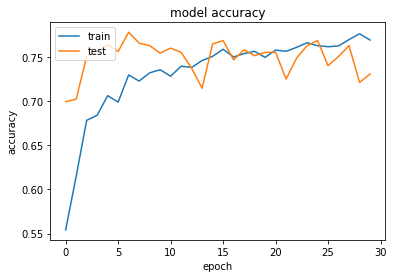

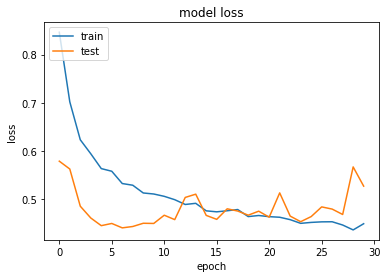

In [57]:
# visualize the accuracy overtime 
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

# visualize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

### Model tunning
- learning rate decay
- Try a different optimization function -RMSprop


In [17]:
# Set a learning rate reduction
from keras.callbacks import ReduceLROnPlateau
learning_rate_reduction = ReduceLROnPlateau(monitor='val_accuracy', 
                                            patience=5, 
                                            verbose=1, 
                                            factor=0.5, 
                                            min_lr=1e-7)

In [23]:
checkpoint = ModelCheckpoint("best_model2.hdf5", monitor='val_accuracy', verbose=1,
    save_best_only=True, mode='auto', period=1)
model2=initiate()
model2.compile(optimizer = Adam(lr = 1e-5) ,loss = "binary_crossentropy", metrics=["accuracy"])
history2 = model2.fit(X_new_train, y_new_train2, 
                     validation_split=0.2,
                     epochs= 30, 
                     batch_size= 64,
                     callbacks=[checkpoint,learning_rate_reduction])

Train on 4219 samples, validate on 1055 samples
Epoch 1/30
4219/4219 [==============================] - 230s 55ms/step - loss: 0.8154 - accuracy: 0.5603 - val_loss: 0.7215 - val_accuracy: 0.5697

Epoch 00001: val_accuracy improved from -inf to 0.56967, saving model to best_model2.hdf5
Epoch 2/30
4219/4219 [==============================] - 251s 59ms/step - loss: 0.6890 - accuracy: 0.6054 - val_loss: 0.5925 - val_accuracy: 0.6398

Epoch 00002: val_accuracy improved from 0.56967 to 0.63981, saving model to best_model2.hdf5
Epoch 3/30
4219/4219 [==============================] - 265s 63ms/step - loss: 0.6441 - accuracy: 0.6459 - val_loss: 0.5996 - val_accuracy: 0.6417

Epoch 00003: val_accuracy improved from 0.63981 to 0.64171, saving model to best_model2.hdf5
Epoch 4/30
4219/4219 [==============================] - 263s 62ms/step - loss: 0.5836 - accuracy: 0.6881 - val_loss: 0.5031 - val_accuracy: 0.7043

Epoch 00004: val_accuracy improved from 0.64171 to 0.70427, saving model to best_mod

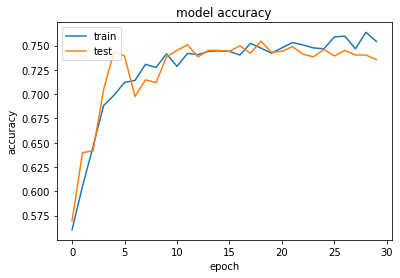

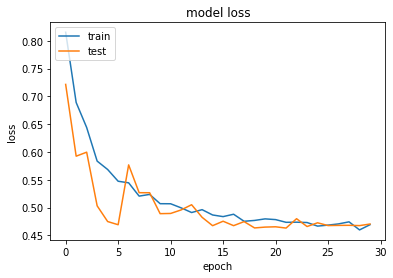

In [24]:
# visualize the accuracy overtime 
plt.plot(history2.history['accuracy'])
plt.plot(history2.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

# visualize history for loss
plt.plot(history2.history['loss'])
plt.plot(history2.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

Using reduced learning rate, the accuracy and loss between the traina and the test set are much loser to each other. We'd prefer this model over the first one because of stronger generalization ability. 
<br> The sign of overfitting appears after epoch 19. We'll stop there.  

In [18]:
# using RMSprop 
checkpoint = ModelCheckpoint("best_model3.hdf5", monitor='val_accuracy', verbose=1,
    save_best_only=True, mode='auto', period=1)
model3=initiate()
model3.compile(optimizer = RMSprop(lr = 1e-5) ,loss = "binary_crossentropy", metrics=["accuracy"])
history3 = model3.fit(X_new_train, y_new_train2, 
                     validation_split=0.2,
                     epochs= 30, 
                     batch_size= 64,
                     callbacks=[checkpoint,learning_rate_reduction])

Train on 4219 samples, validate on 1055 samples
Epoch 1/30
4219/4219 [==============================] - 268s 63ms/step - loss: 0.7307 - accuracy: 0.6051 - val_loss: 0.5796 - val_accuracy: 0.7242

Epoch 00001: val_accuracy improved from -inf to 0.72417, saving model to best_model3.hdf5
Epoch 2/30
4219/4219 [==============================] - 260s 62ms/step - loss: 0.6457 - accuracy: 0.6589 - val_loss: 0.5161 - val_accuracy: 0.7346

Epoch 00002: val_accuracy improved from 0.72417 to 0.73460, saving model to best_model3.hdf5
Epoch 3/30
4219/4219 [==============================] - 265s 63ms/step - loss: 0.5857 - accuracy: 0.6957 - val_loss: 0.4847 - val_accuracy: 0.7526

Epoch 00003: val_accuracy improved from 0.73460 to 0.75261, saving model to best_model3.hdf5
Epoch 4/30
4219/4219 [==============================] - 259s 62ms/step - loss: 0.5597 - accuracy: 0.7191 - val_loss: 0.5119 - val_accuracy: 0.7204

Epoch 00004: val_accuracy did not improve from 0.75261
Epoch 5/30
4219/4219 [=======

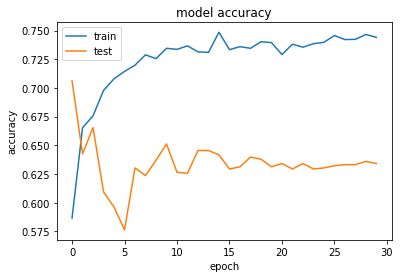

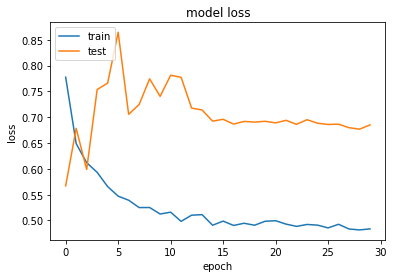

In [22]:
# visualize the accuracy overtime 
plt.plot(history3.history['accuracy'])
plt.plot(history3.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

# visualize history for loss
plt.plot(history3.history['loss'])
plt.plot(history3.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

The RMSprop optimization function does not yield higher accuracy. We prefer model 2. 

### predict on the holdout set
Using model2 to predict on the holdout set

In [37]:
from keras.models import load_model
model = load_model('best_model2.hdf5')
# predict on the holdout set
results2=pd.DataFrame(model.predict(X_holdout))
# convert to 0/1
results=(results2[1]>0.5)*1
# calculate the acc on the holdout set
holdout_acc=(sum(results==y_holdout))/len(y_holdout)
holdout_acc

0.7787878787878788

In [38]:
# precision 
tp=(results==y_holdout)&(results==1)
fp=(results!=y_holdout)&(results==1)
pos=results==1
precision=tp.sum()/pos.sum()
precision

0.7938931297709924

In [39]:
# Recall tp/tp+fn
fn=(results!=y_holdout)&(results==0)
recall=tp.sum()/(tp.sum()+fn.sum())
recall

0.6933333333333334

The accuracy is slightly lower than random forest. More importantly, the recall is much lower (compared to 0.833). In the initial screening process of cancer detection, recall is more important than precision. A false positive can be corrected later through a biopsy, but a false negative can be very costly.

We'd prefer random forest over the CNN model.

## visualize some misclassified images 

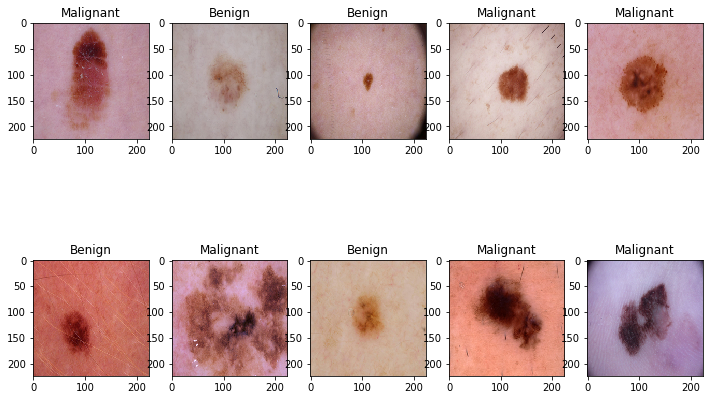

In [40]:
# find the misclassified images
mis=results!=y_holdout
X_mis=X_holdout[mis]
y_mis=y_holdout[mis]

# Display first 10 misclassified images of moles, with the true label 
w=40
h=30
fig=plt.figure(figsize=(12, 8))
columns = 5
rows = 2

for i in range(1, columns*rows +1):
    ax = fig.add_subplot(rows, columns, i)
    if y_mis[i] == 0:
        ax.title.set_text('Benign')
    else:
        ax.title.set_text('Malignant')
    plt.imshow(X_mis[i], interpolation='nearest')
plt.show()